In [1]:
### Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('GMM').getOrCreate()

In [2]:
### Spark ML Imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.linalg import Vectors

In [3]:
### Pyhton Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from PIL import Image
from collections import Counter
from scipy import ndimage

In [4]:
# Display parameters
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


(800, 800)


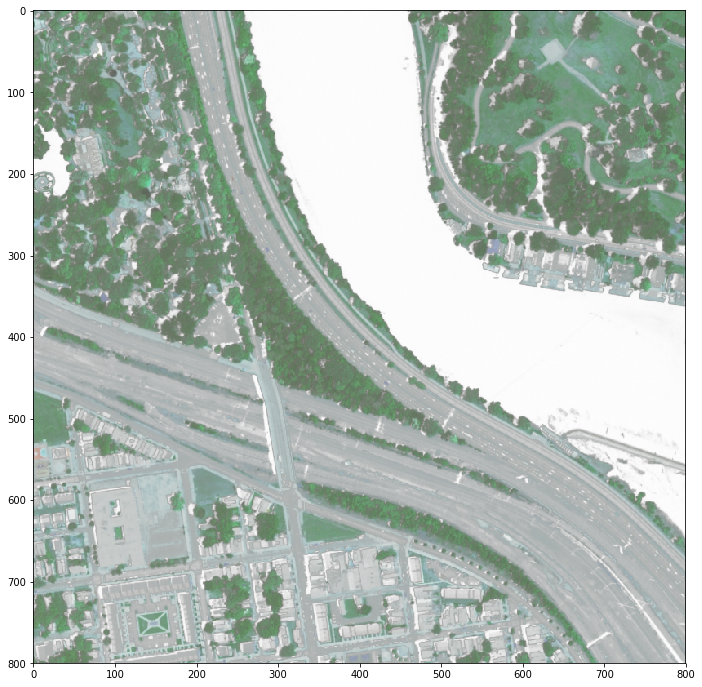

In [5]:
# Read image
fileName = "NAIP_minis/4800_3200.tif"
image = Image.open(fileName)
imageW = image.size[0]
imageH = image.size[1]

# Number of clusters
K = 5

# To mask out non-vegetation region
mask_flag = 0

print (image.size)
plt.imshow(image)

In [6]:
# Initialise dataVector with attributes for each pixel
dataVector = np.ndarray(shape=(imageW * imageH, 12), dtype=float)

# Populate data vector with data from input image
for y in range(0, imageH):
    for x in range(0, imageW):
        xy = (x, y)
        rgb = image.getpixel(xy)
        
        dataVector[x + y * imageW, 0] = rgb[0]
        dataVector[x + y * imageW, 1] = rgb[1]
        dataVector[x + y * imageW, 2] = rgb[2]
        dataVector[x + y * imageW, 3] = rgb[3]
        dataVector[x + y * imageW, 4] = 0
        dataVector[x + y * imageW, 5] = 0
        dataVector[x + y * imageW, 6] = 0
        dataVector[x + y * imageW, 7] = 0
        dataVector[x + y * imageW, 8] = 0
        dataVector[x + y * imageW, 9] = 0
        dataVector[x + y * imageW, 10] = x
        dataVector[x + y * imageW, 11] = y

In [7]:
# NDVI calculation
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + dataVector[:, 0])

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 4] = num / den

In [8]:
# EVI calculation
G = 2.5
L = 1
C1 = 6
C2 = 7.5
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + (C1 * dataVector[:, 0]) - (C2 * dataVector[:, 2]) + L)

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 5] = num / den

In [9]:
# ARVI calculation
num = (dataVector[:, 3] - (2 * dataVector[:, 0] - dataVector[:, 2]))
den = (dataVector[:, 3] + (2 * dataVector[:, 0] + dataVector[:, 2]))

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 6] = (num/den)

In [10]:
# VARI calculation
num = (dataVector[:, 1] - dataVector[:, 0])
den = (dataVector[:, 0] + dataVector[:, 1] + dataVector[:, 2])

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 7] = (num/den)

In [11]:
# SAVI calculation
L = 0.5
num = (dataVector[:, 3] - dataVector[:, 0])
den = (dataVector[:, 3] + dataVector[:, 0] + L)

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 8] = (num/den) * (1 + L)

In [12]:
# CI calculation
num = (dataVector[:, 0] - dataVector[:, 2])
den = (dataVector[:, 0] + dataVector[:, 2])

idx = np.where(den == 0)
num[idx] = 0
den[idx] = 1

dataVector[:, 9] = (num/den)

In [13]:
# Mask non-vegetation pixels
maskName = fileName[11:-4] + "_mask.npy"
maskPath = "NAIP_masksnpy/" + str(maskName)
mask = np.load(maskPath)
idx_mask = np.array(np.where(mask==mask_flag)[0])
dataVector_mask = dataVector[idx_mask]

In [14]:
# Convert Numpy array to Pandas Dataframe
temp_df = pd.DataFrame(dataVector_mask[:, 0:10], columns=list('RGBINEAVSC'))
temp_df = temp_df.fillna(0)

In [15]:
# Generate feature vector from Spark Dataframe
df = spark.createDataFrame(temp_df)
vecAssembler = VectorAssembler(inputCols=["R", "G", "B", "I", "N", "E", "A", "V", "S", "C"], outputCol="features")
new_df = vecAssembler.transform(df)

In [16]:
# Clustering into k clusters
gm = GaussianMixture(k=K, tol=0.0001, maxIter=10, seed=1)
model = gm.fit(new_df.select('features'))
transformed = model.transform(new_df)

In [17]:
# Extract the features for each pixel
feats = np.array(transformed.select('features').collect())
feats = feats.reshape(idx_mask.shape[0], 10)

In [18]:
# Extract the cluster IDs for each pixel
pixelClusterAppartenance = np.array(transformed.select('prediction').collect())
pixelClusterAppartenance.shape

(359565, 1)

In [19]:
# To assign black (-1) colour to masked pixels
tmp_arr = np.zeros(((imageW*imageH), 1))
tmp_arr[:] = -1
tmp_arr[idx_mask] = pixelClusterAppartenance

In [20]:
# Assign colour based on most frequent clusterID
idx = Counter(list(pixelClusterAppartenance.flatten()))
idx = idx.most_common()
idx = [idx[i][0] for i in range(len(idx))]
idx = np.array(idx)

In [21]:
# ['green', 'blue', 'darkorange', 'deeppink', 'white', 'crimson']
clr_lst = ['00FF00', '0000FF', 'FF8C00', 'FF1493', 'FFFFFF', 'DC143C']
clr_lst = clr_lst[:K]

In [22]:
# Convert hex color representations to RGB values
colors = []
for index in range(K):
    rgb = list(int(clr_lst[index][i:i+2], 16) for i in (0, 2 ,4))
    colors.append(rgb)
    
color = np.array(colors)

In [23]:
# Convert list of arrays to matrix
dataVector = np.ndarray(shape=(imageW * imageH, 3), dtype=float)

for index, item in enumerate(tmp_arr):
    
    if item == -1:
        dataVector[index][0] = 0
        dataVector[index][1] = 0
        dataVector[index][2] = 0
        continue
    
    dataVector[index][0] = int(color[int(np.where(idx==item)[0][0]), 0])
    dataVector[index][1] = int(color[int(np.where(idx==item)[0][0]), 1])
    dataVector[index][2] = int(color[int(np.where(idx==item)[0][0]), 2])

In [24]:
# Fill clusters
image = Image.new("RGB", (imageW, imageH))

for y in range(imageH):
    for x in range(imageW):
        image.putpixel((x, y), (int(dataVector[y * imageW + x][0]), 
                                int(dataVector[y * imageW + x][1]),
                                int(dataVector[y * imageW + x][2])))

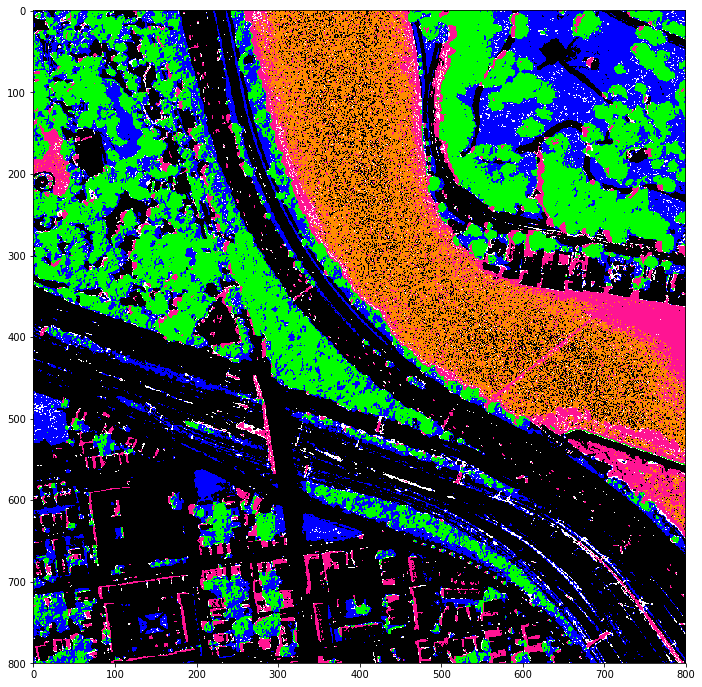

In [25]:
# Display mask
plt.imshow(image)